In this notebook, we are analyzing the results of the CaseOLAP text mining association between 8 CVDs and protein groups representing cardiac proteins extracted from experimental dataset in 4 mammalian species (human, mouse, rat, pig).

Steps:
 1. Hierarchical clustering + PCA on results
 2. Calculate z-scores 
 3. Identify subproteomes w.r.t each CVD
     3.1 Violin plot
 4. Identify Protein Group Categories
 5. 

### Make a copy of the CaseOLAP text mining association results to this folder

In [1]:
! ls -lh ../caseolap/result/caseolap.csv
! cp ../caseolap/result/caseolap.csv .

-rw-rw-r-- 1 ubuntu ubuntu 993K May 19 19:34 ../caseolap/result/caseolap.csv


In [2]:
# # also copy log file
! ls -lh ../caseolap/result/ranked_ent2syn2count.json 
! cp ../caseolap/result/ranked_ent2syn2count.json .

-rw-rw-r-- 1 ubuntu ubuntu 3.3M Jun 17 18:34 ../caseolap/result/ranked_ent2syn2count.json


In [3]:
! ls -lh

total 12M
-rw-rw-r-- 1 ubuntu ubuntu 2.4M Jul  7 00:19 '2022-05-19 Pathway Analysis Post Processing with dendrogram.ipynb'
-rw-rw-r-- 1 ubuntu ubuntu 1.9M Jul 11 22:59 '2022-07-06 Post Processing and Pathway Analysis .ipynb'
-rw-rw-r-- 1 ubuntu ubuntu 993K Jul 11 22:59  caseolap.csv
-rw-rw-r-- 1 ubuntu ubuntu  33K Jul  6 20:30  caseolap_zscore_violin_plot.pdf
-rw-rw-r-- 1 ubuntu ubuntu 2.3M Jun 16 21:06  combined_aliases.txt
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 25 23:26  output
-rw-rw-r-- 1 ubuntu ubuntu  34K Jul  7 00:05  pathways_unique_to_cvd_heatmap.pdf
-rw-rw-r-- 1 ubuntu ubuntu 3.3M Jul 11 22:59  ranked_ent2syn2count.json
drwxrwxr-x 2 ubuntu ubuntu 4.0K Jun 14 20:46  reactome_data
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 25 22:54  reactome_results
drwxrwxr-x 2 ubuntu ubuntu 4.0K Jul  6 20:28  results
-rw-rw-r-- 1 ubuntu ubuntu 345K May 24 21:55  results.csv
drwxrwxr-x 3 ubuntu ubuntu 4.0K Jul  6 21:14  scratch
-rw-rw-r-- 1 ubuntu ubuntu 189K Jun 16 21:06  synonymcount_log.txt


In [4]:
! date

Mon Jul 11 22:59:47 UTC 2022


### Download latest Reactome data

In [15]:
! wget https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt
! wget https://reactome.org/download/current/ReactomePathwaysRelation.txt
! wget https://reactome.org/download/current/ReactomePathways.txt

! mv UniProt2Reactome_All_Levels.txt ./reactome_data
! mv ReactomePathwaysRelation.txt ./reactome_data
! mv ReactomePathways.txt ./reactome_data

--2022-07-19 19:19:15--  https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112995618 (108M) [text/plain]
Saving to: ‘UniProt2Reactome_All_Levels.txt’

UniProt2Reactome_Al 100%[===================>] 107.76M  24.1MB/s    in 4.9s    

2022-07-19 19:19:20 (22.0 MB/s) - ‘UniProt2Reactome_All_Levels.txt’ saved [112995618/112995618]

--2022-07-19 19:19:20--  https://reactome.org/download/current/ReactomePathwaysRelation.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587577 (574K) [text/plain]
Saving to: ‘ReactomePathwaysRelation.txt’

ReactomePathwaysRel 100%[===================>] 573.81K  1.34MB/s    in 0.4s    

2022-07-19 19:19:21 (1.34 MB/s) - ‘Rea

### Imports, input file paths, and notebook variables

In [1]:
from cardiac_proteome_caseolap._03_text_mining_association_analysis import *

In [2]:
### input files ###
caseolap_results_file = "./caseolap_results_analysis/caseolap.csv"
prot_to_uniref_file = './cardiac_proteome_curation/human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv'
reactome_uniprot_to_pathway = "./reactome_data/UniProt2Reactome_All_Levels.txt"
reactome_hierarchy_to_pathway = "./reactome_data/ReactomePathwaysRelation.txt"
reactome_id_to_pathway_name = "./reactome_data/ReactomePathways.txt"

# synonym related files for redundancy removal
entity_count_file = "./caseolap/result/ranked_ent2syn2count.json"

In [3]:
z_score_threshold = 3.0

In [4]:
# load CaseOLAP scores
raw_caseolap_scores = pd.read_csv(caseolap_results_file)

In [5]:
raw_caseolap_scores

,protein,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
0,UniRef90_Q5SF07-2,0.000000,0.013978,0.000000,0.016263,0.000000,0.000000,0.000000,0.000000
1,UniRef90_S4R3U1,0.009267,0.009541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,UniRef90_F1SID7,0.022570,0.070068,0.032458,0.112651,0.032643,0.028304,0.011128,0.049038
3,UniRef90_D6RF25,0.032819,0.006016,0.000000,0.000000,0.006724,0.000000,0.000000,0.016352
4,UniRef90_F2Z393,0.000000,0.019085,0.000000,0.000000,0.000000,0.000000,0.000000,0.006329
...,...,...,...,...,...,...,...,...,...
10191,UniRef90_P07358,0.011694,0.000000,0.010709,0.000000,0.000000,0.000000,0.000000,0.000000
10192,UniRef90_H0YAN3,0.016419,0.013978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10193,UniRef90_A0A4X1UPC8,0.028182,0.016895,0.020277,0.011093,0.010658,0.000000,0.000000,0.018988
10194,UniRef90_Q5D144,0.028714,0.035924,0.026373,0.000000,0.000000,0.000000,0.000000,0.032553


## Combine Redundant ProteinGroups

In [6]:
uniref_to_uniprot_list, map_df = parse_uniref_to_uniprot_list(prot_to_uniref_file,debug=True)   
ranked_ent_df = prepare_ranked_ent(entity_count_file)
id_to_synonym = prepare_synonyms(ranked_ent_df)

merged = merge_UniRefIDs(map_df, id_to_synonym, raw_caseolap_scores)
merged   

21732 uniref ids and 30571 uniprot ids parsed


,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,F8W930; Q9Y6M1; F1SFK0,IGF2BP2,0.000000,0.013978,0.000000,0.016263,0.000000,0.000000,0.000000,0.000000
UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,B1AUU8; P42566; S4R3U1,epidermal growth factor receptor substrate 15,0.009267,0.009541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UniRef90_F1SID7,F1SID7,"Myosin Binding Protein C3, myosin binding protein C3, MYBPC3, Myosin binding protein C3",0.022570,0.070068,0.032458,0.112651,0.032643,0.028304,0.011128,0.049038
UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,A0A0A0MSR2; E7EV99; D6RJE2; H0YG19; P35611; E7ENY0; H0Y9H2; D6RAH3; D6RF25,"ADD1, alpha-Adducin, Alpha-adducin, alpha-adducin",0.032819,0.006016,0.000000,0.000000,0.006724,0.000000,0.000000,0.016352
UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,E9PKI8; E9PM01; F2Z393,"transaldolase, TALDO1",0.000000,0.019085,0.000000,0.000000,0.000000,0.000000,0.000000,0.006329
...,...,...,...,...,...,...,...,...,...,...
UniRef90_Q92905,Q92905,CSN5,0.011694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021902
UniRef90_Q07076,Q07076; A0A5G2R850; P20073,"annexin A7, Annexin A7",0.005845,0.012036,0.023380,0.007000,0.006726,0.025547,0.007997,0.014692
UniRef90_P01344,P01344,"insulin-like growth factor II, Insulin-like growth factor II, IGF2",0.025691,0.027248,0.017449,0.019648,0.030951,0.014739,0.012662,0.026890


In [7]:
print("Number of merged protein groups before merging: %d"%raw_caseolap_scores.shape[0])
print("Number of merged protein groups after merging by synonyms: %d"%merged.shape[0])
print("%f%% of original number"%(100*merged.shape[0]/raw_caseolap_scores.shape[0]))

Number of merged protein groups before merging: 10196
Number of merged protein groups after merging by synonyms: 5637
55.286387% of original number


# Hierarchical clustering + PCA on results

In [8]:
df = merged.copy(deep=True).reset_index().drop(["Mapped Proteins","Synonyms"],axis=1)
# df = df.reset_index()
df.head()
# df['protein'] = 

,Protein Groups,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
0,UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,0.000000,0.013978,0.000000,0.016263,0.000000,0.000000,0.000000,0.000000
1,UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,0.009267,0.009541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,UniRef90_F1SID7,0.022570,0.070068,0.032458,0.112651,0.032643,0.028304,0.011128,0.049038
3,UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,0.032819,0.006016,0.000000,0.000000,0.006724,0.000000,0.000000,0.016352
4,UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,0.000000,0.019085,0.000000,0.000000,0.000000,0.000000,0.000000,0.006329


In [9]:
# print(df.shape)
print("%d unique UniRef IDs associated with at least one CVD"%(df.shape[0]))
print("%d protein group-disease relationships (including 0's)"%(df.shape[0]*df.shape[1]))
print("%d nonzero protein group-disease relationships" %(np.count_nonzero(df,axis=None)))
print("%d zero protein group-disease relationships" %(df.shape[0]*df.shape[1] - np.count_nonzero(df,axis=None)))

# all cardiovascular disease types
cvds = list(df.columns)[1:]

# make a boolean (True/False) table from original data
df_bool = df.copy()
for col in cvds:
    df_bool[col] = df[col] > 0

# get only rows with all true

all_true_df_bool = df_bool[df_bool[cvds].T.all()]
unirefs_in_all = set(all_true_df_bool['Protein Groups'])
print("%d UniRef90 IDs were found in all %s CVDs"%(len(unirefs_in_all),len(cvds)))

5637 unique UniRef IDs associated with at least one CVD
50733 protein group-disease relationships (including 0's)
23524 nonzero protein group-disease relationships
27209 zero protein group-disease relationships
335 UniRef90 IDs were found in all 8 CVDs


In [10]:
def uniref_list_to_protein_list(uniref_ids, uniref_to_uniprot_list, debug=False):
    all_proteins = set()
    num_uniref = 0
    for uniref_list in uniref_ids:
        for uniref_id in uniref_list.split("; "):
            proteins = set(uniref_to_uniprot_list[uniref_id])
            all_proteins = all_proteins.union(proteins)
            num_uniref += 1
    if debug:
        print("%d proteins associated to %d uniref IDs"%(len(all_proteins),num_uniref))
    return all_proteins

all_associated_proteins = uniref_list_to_protein_list(df['Protein Groups'],uniref_to_uniprot_list,debug=True)

14445 proteins associated to 10196 uniref IDs


In [11]:
for cvd in cvds:
    max_val = np.max(df[cvd])
    max_idx = df[cvd].idxmax()
    prot_group = df.iloc[max_idx]['Protein Groups']
    print(cvd, max_val,prot_group)


IHD 0.1848355183274148 UniRef90_H0YJG0; UniRef90_F8WCN3; UniRef90_A0A0G2JVQ1; UniRef90_H0YJK0; UniRef90_G3V461; UniRef90_P12532
CM 0.1246838019521497 UniRef90_P12821
ARR 0.149743284245183 UniRef90_Q9JJV9
VD 0.112651017146739 UniRef90_F1SID7
CHD 0.1700053877735026 UniRef90_Q61554
CCD 0.2064580317876307 UniRef90_Q9JJV9
VOO 0.0975191002285604 UniRef90_E7EN65; UniRef90_P15502; UniRef90_B3KRT8; UniRef90_Q99372; UniRef90_G5E950
OTH 0.0918753123764784 UniRef90_Q8R0I0


It is interesting that ARR and CCD have the same protein: Sodium Channel Protein Type 5 Subunit Alpha

In [12]:
merged[merged.index == "UniRef90_Q8R0I0"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_Q8R0I0,D3ZYK4,"Ace2, Angiotensin-converting Enzyme, Angiotensin-Converting Enzyme, angiotensin-converting enzyme, Angiotensin-converting enzyme",0.102659,0.124634,0.05804,0.045686,0.035347,0.038873,0.040846,0.091875


In [13]:
merged[merged.index == "UniRef90_P12821"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P12821,P12821,"kininase II, DCP1, Angiotensin-converting Enzyme, Angiotensin-Converting Enzyme, angiotensin-converting enzyme, Angiotensin-converting enzyme",0.103117,0.124684,0.05842,0.045659,0.035326,0.038849,0.040822,0.09124


IHD:
The UniRef90 IDs UniRef90_H0YJG0; UniRef90_F8WCN3; UniRef90_A0A0G2JVQ1; UniRef90_H0YJK0; UniRef90_G3V461; UniRef90_P12532 correspond to the proteins H0YJG0; F8WCN3; A0A0G2JVQ1; H0YJK0; G3V461; F1SI77 which is Creatine Kinase. 

CM:
The UniRef90 ID UniRef90_P12821 corresponds to the protein P12821 which is Angiotensin-Converting Enzyme.

ARR:
The UniRef90 ID UniRef90_Q9JJV9 corresponds to the proteins A0A0R4J1M7; Q9JJV9; F1LNF5; P15389 which is Sodium Channel Protein Type 5 Subunit Alpha.

VD:
The UniRef90 ID UniRef90_F1SID7 corresponds to the protein F1SID7 which is Myosin Binding Protein C3.

CHD:
The UniRef90 ID UniRef90_Q61554 corresponds to the protein Q61554 Fibrillin-1.

CCD:
The UniRef90 ID UniRef90_Q9JJV9 corresponds to the proteins A0A0R4J1M7; Q9JJV9; F1LNF5; P15389 which is Sodium Channel Protein Type 5 Subunit Alpha. Note: this is the same for ARR. 

VOO:
The UniRef90 IDs UniRef90_E7EN65; UniRef90_P15502; UniRef90_B3KRT8; UniRef90_Q99372; UniRef90_G5E950 correspond to the proteins E7EN65; E7ENM0; P15502; B3KRT8; P54320; A0A0G2JST5; G5E950 which is Elastin. 

OTH:
The UniRef90 ID UniRef90_Q8R0I0 corresponds to the protein D3ZYK4 which is Angiotensin-Converting Enzyme according to the 'merged' data frame. This is the same as CM but the UniRef ID is different. However, I checked and the protein ID D3ZYK4 is actually obselete in UniProt.


          IHD        CM       ARR        VD       CHD       CCD       VOO  \
2    0.022570  0.070068  0.032458  0.112651  0.032643  0.028304  0.011128   
64   0.079643  0.060707  0.041582  0.031714  0.028085  0.023884  0.024910   
75   0.040460  0.081827  0.040848  0.035847  0.035271  0.032445  0.020741   
86   0.184831  0.083380  0.059336  0.039728  0.032328  0.046295  0.035747   
132  0.142662  0.080923  0.058590  0.060233  0.038438  0.042852  0.037615   

          OTH  
2    0.049038  
64   0.040419  
75   0.071049  
86   0.050580  
132  0.063411  
(134, 8)
0.2064580317876307


/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:292: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


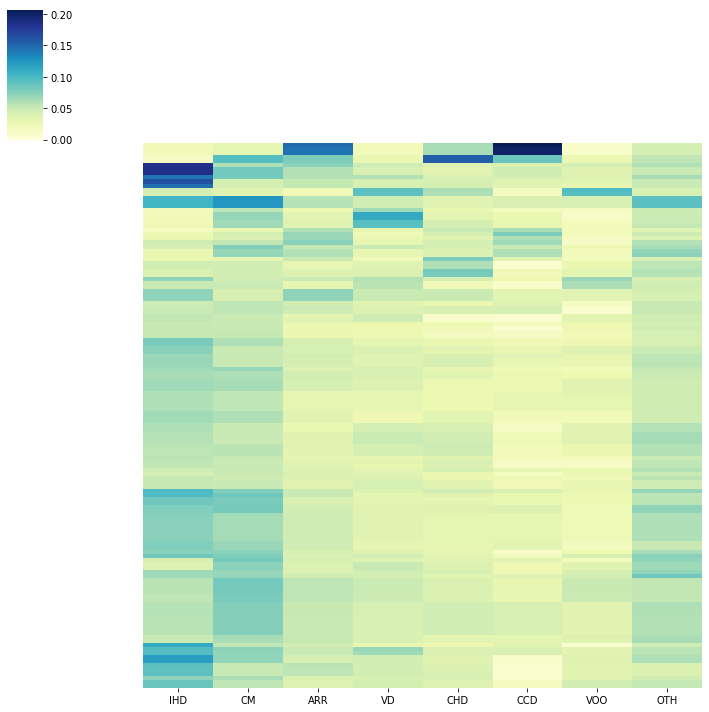

In [14]:
sub_df = df[df['Protein Groups'].isin(unirefs_in_all)]
make_caseolap_score_heatmap(sub_df)

explained variance
[0.61275527 0.12142886 0.08791147 0.05644506 0.04994068 0.03079019
 0.022637   0.01809147]
singular values
[166.23119916  73.99970286  62.96392508  50.4524161   47.45655759
  37.26277679  31.95055449  28.5631393 ]


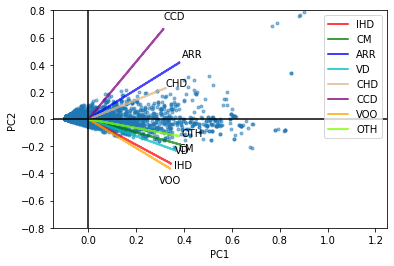

/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:380: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


In [15]:
make_caseolap_pca(df)

Similarities among CVDs, as presented here, represent their conceptual similarities as determined by each CVD’s associations with specific protein groups. In brief, similar vectors in this plot represent diseases with similar protein involvement as per the literature.



# Calculate z-score

In [16]:
# df is the original CaseOLAP scores matrix.
zscores_df = convert_to_zscore(df, include_zeros = False)
zscores_df=zscores_df.set_index('Protein Groups')
zscores_df.head()

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,
UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,NaN,-0.452850,NaN,-0.214451,NaN,NaN,NaN,NaN
UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,-0.716108,-0.766405,NaN,NaN,NaN,NaN,NaN,NaN
UniRef90_F1SID7,0.109163,3.511620,0.923204,7.245177,1.098864,0.492113,-0.708644,2.179917
UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,0.745009,-1.015601,NaN,NaN,-0.827650,NaN,NaN,-0.318482
UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,NaN,-0.091847,NaN,NaN,NaN,NaN,NaN,-1.084649


In [17]:
zscores_df.to_csv("./results/merged_caseolap_zscores.csv",index=True)

# 3. Identifying Protein Groups of interest


In [18]:
#reading the csv file
summary_table = pd.read_csv("./results/merged_caseolap_zscores.csv")
summary_table = summary_table.set_index('Protein Groups') 
z_score_threshold=3

#obtaining list of CVDs
CVDs = list(summary_table.columns)
print(CVDs)
summary_table.head()

['IHD', 'CM', 'ARR', 'VD', 'CHD', 'CCD', 'VOO', 'OTH']


,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,
UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,NaN,-0.452850,NaN,-0.214451,NaN,NaN,NaN,NaN
UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,-0.716108,-0.766405,NaN,NaN,NaN,NaN,NaN,NaN
UniRef90_F1SID7,0.109163,3.511620,0.923204,7.245177,1.098864,0.492113,-0.708644,2.179917
UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,0.745009,-1.015601,NaN,NaN,-0.827650,NaN,NaN,-0.318482
UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,NaN,-0.091847,NaN,NaN,NaN,NaN,NaN,-1.084649


## 3.1 Identify Subproteomes w.r.t each CVD

In [19]:
#Sub-proteomes: Proteins with z-score above the threshold

sub_proteome_headers = []
for cvd in CVDs:
    cvd_sub = cvd + " Sub-proteome"
    summary_table[cvd_sub] = summary_table[cvd] >= z_score_threshold
    sub_proteome_headers += [cvd_sub]

summary_table[sub_proteome_headers].sort_values(sub_proteome_headers[0],ascending=False).head()

,IHD Sub-proteome,CM Sub-proteome,ARR Sub-proteome,VD Sub-proteome,CHD Sub-proteome,CCD Sub-proteome,VOO Sub-proteome,OTH Sub-proteome
Protein Groups,,,,,,,,
UniRef90_P00750,True,False,False,False,False,False,False,False
UniRef90_A0A4X1TQT5; UniRef90_A0A4X1TW19,True,False,False,False,False,False,False,False
UniRef90_P14847; UniRef90_P48199; UniRef90_O19062; UniRef90_A0A0G2K8V5; UniRef90_Q5VVP7; UniRef90_P02741,True,False,True,False,False,False,False,True
UniRef90_P12821,True,True,False,False,False,False,False,True
UniRef90_A0A0G2JZ66,True,True,False,False,False,False,False,True


In [20]:
# extract the z-scores of protein groups in the subproteome for each CVD
cvd_subproteome_to_scores = {}
for cvd in CVDs:
    
    # extract protein groups in subproteome
    tag = cvd+' Sub-proteome'
    unirefs_in_subproteome = set(summary_table[summary_table[tag]].index)
    proteins_in_subproteome = uniref_list_to_protein_list(unirefs_in_subproteome,uniref_to_uniprot_list)
    print("%s %d unique UniRef90 IDs and %d proteins"%(tag,len(unirefs_in_subproteome),len(proteins_in_subproteome)))
    
    # extract z-scores
    scores = list(summary_table[summary_table.index.isin(unirefs_in_subproteome)][cvd])
    cvd_subproteome_to_scores[cvd] = scores

IHD Sub-proteome 55 unique UniRef90 IDs and 132 proteins
CM Sub-proteome 65 unique UniRef90 IDs and 159 proteins
ARR Sub-proteome 19 unique UniRef90 IDs and 37 proteins
VD Sub-proteome 17 unique UniRef90 IDs and 49 proteins
CHD Sub-proteome 35 unique UniRef90 IDs and 69 proteins
CCD Sub-proteome 12 unique UniRef90 IDs and 22 proteins
VOO Sub-proteome 5 unique UniRef90 IDs and 16 proteins
OTH Sub-proteome 34 unique UniRef90 IDs and 95 proteins


### Figure X. z-score distribution and Sub-proteome Violin Plot

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


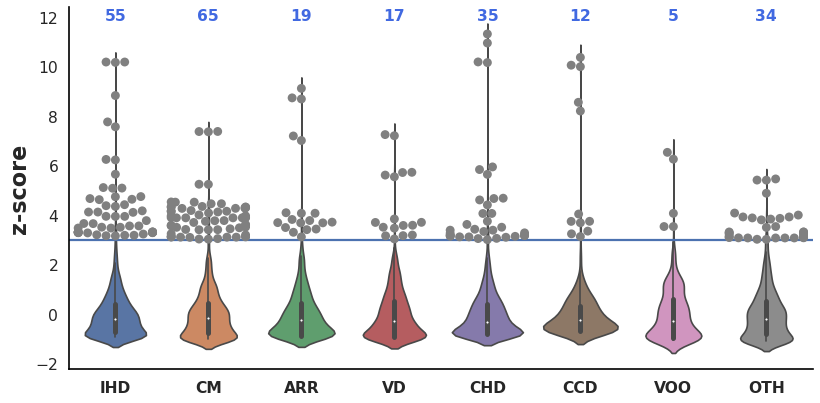

In [21]:
# prepare plot values above threshold line
subproteome_plot_values = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in cvd_subproteome_to_scores.items() ]))

cvd_proteomes_violin_plot(zscores_df,subproteome_plot_values)

## 3.2 Category I Protein Groups

In [23]:
#Category I: Protein groups with score > 0 for all CVDs
summary_table['Category I'] = (summary_table.isnull().sum(axis=1) == 0)
temp = CVDs + ['Category I']
summary_table[summary_table['Category I']==True][temp].head()

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH,Category I
Protein Groups,,,,,,,,,
UniRef90_F1SID7,0.109163,3.511620,0.923204,7.245177,1.098864,0.492113,-0.708644,2.179917,True
UniRef90_D3ZYH8; UniRef90_K7GRV6; UniRef90_J3QSF7,3.649864,2.849976,1.560124,0.981360,0.760067,0.247264,0.445864,1.521158,True
UniRef90_P02786,0.641395,0.940637,0.760511,-0.217851,0.902340,0.659381,-0.972832,1.204193,True
UniRef90_A2A9Z1; UniRef90_P11531; UniRef90_A0A2K5CIC9; UniRef90_Q5GN48; UniRef90_P11532-2; UniRef90_P11532-15; UniRef90_A0A0C4DH61; UniRef90_P11530; UniRef90_D3ZEK8; UniRef90_A0A0B4J1W6; UniRef90_P11532,1.219053,4.342688,1.508902,1.301216,1.294143,0.721570,0.096598,3.862393,True
UniRef90_F7CJI9; UniRef90_A0A4X1T7M8,10.175616,4.452493,2.799547,1.601536,1.075448,1.488945,1.353595,2.297832,True


In [24]:
# print out summary statistics
category_i_unirefs = set(summary_table[summary_table['Category I']==True].index)
category_i_proteins = uniref_list_to_protein_list(category_i_unirefs,uniref_to_uniprot_list)

print("%d unique protein groups and %d proteins in Category I"%(len(category_i_unirefs), len(category_i_proteins)))

335 unique protein groups and 827 proteins in Category I


### Figure X. Category I heatmap

/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:564: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


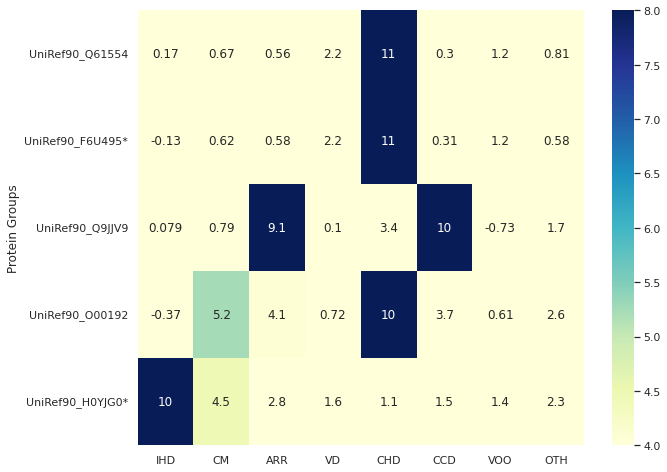

In [82]:
make_category_i_heatmap(summary_table[summary_table['Category I']==True][CVDs], sort_by='max')

/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:564: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


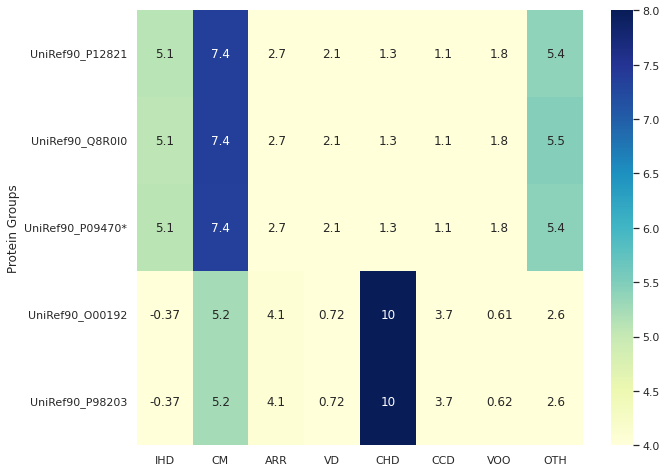

In [26]:
make_category_i_heatmap(summary_table[summary_table['Category I']==True][CVDs], sort_by='mean')

Observations: Top scoring protein is mostly blank, but it has a high average.

TODO: 
* think about how we want to present the top scoring proteins
* why is row 2 and 3 numerically similar, but they must be different in the synonyms?
* consider not showing this heatmap, it overlaps with a lot of others... (Category II or Category III)

## 3.3 Category II Protein Groups

These protein groups are above z-score for only one CVD. Determine appropriate z-score threshold, use this analysis.

In [27]:
zscore_cutoff_table(zscores_df)

,z-score cutoff,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
0,1.0,88,60,17,19,68,0,8,45
1,2.0,35,17,13,9,36,0,2,19
2,3.0,22,21,3,6,24,0,2,4
3,5.0,9,0,0,4,3,0,0,0
4,10.0,3,0,0,0,4,2,0,0


TODO:
* Look at which CVDs are most similar to CCD that cause no protein groups to be uniquely significant
* what are the 2 protein groups that show up at t=10 threshold in CCD but not for the others? -> maybe these proteins play a role in other CVDs but is most related to CCD?

In [28]:
print("z-score threshold used for this analysis: %f"%(z_score_threshold))

z-score threshold used for this analysis: 3.000000


In [29]:
# Category II: explaionaation here

category_ii_headers = []
for cvd in CVDs:
    cvd_sub = cvd + " Sub-proteome"
    cvd_catII = cvd + " Category II"

    #gets the cvds that are not the ones of current interest
    cvd_other = [other for other in CVDs if (other != cvd)]

    #accesses the sub-proteome columns of the "other" cvds
    cvd_other = [x+" Sub-proteome" for x in cvd_other]

    #the new category column is if the sub-proteome of interest is >= 3 and the other sub-proteomes are <= 3
    summary_table[cvd_catII] = summary_table[cvd_sub] & ~((summary_table[cvd_other]).any(bool_only=True,axis='columns'))

    category_ii_headers += [cvd_catII]
    
# summary_table[category_ii_headers].head()


In [30]:
# print out summary statistics
for col_name in summary_table.columns:
    if col_name in category_ii_headers:
        num_true = summary_table[col_name].sum()
        print("%s\t%d"%(col_name,num_true))

IHD Category II	22
CM Category II	21
ARR Category II	3
VD Category II	6
CHD Category II	24
CCD Category II	0
VOO Category II	2
OTH Category II	4


In [31]:
summary_table[category_ii_headers].sort_values('IHD Category II', ascending = False).head()

,IHD Category II,CM Category II,ARR Category II,VD Category II,CHD Category II,CCD Category II,VOO Category II,OTH Category II
Protein Groups,,,,,,,,
UniRef90_P18648; UniRef90_P02647,True,False,False,False,False,False,False,False
UniRef90_A0A8D1FEU4,True,False,False,False,False,False,False,False
UniRef90_P70496; UniRef90_Q9Z280-2,True,False,False,False,False,False,False,False
UniRef90_P00750,True,False,False,False,False,False,False,False
UniRef90_Q01102,True,False,False,False,False,False,False,False


In [32]:
summary_table[category_ii_headers].sort_values('CM Category II', ascending = False).head()

,IHD Category II,CM Category II,ARR Category II,VD Category II,CHD Category II,CCD Category II,VOO Category II,OTH Category II
Protein Groups,,,,,,,,
UniRef90_A0A4X1THK6; UniRef90_A0A2K5USK5,False,True,False,False,False,False,False,False
UniRef90_A0A4X1WE35; UniRef90_G3V3R6,False,True,False,False,False,False,False,False
UniRef90_I3L6S5,False,True,False,False,False,False,False,False
UniRef90_P50390,False,True,False,False,False,False,False,False
UniRef90_P62894; UniRef90_P99999,False,True,False,False,False,False,False,False


### Figure X heatmap. Top 3 in each CVD

/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:618: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


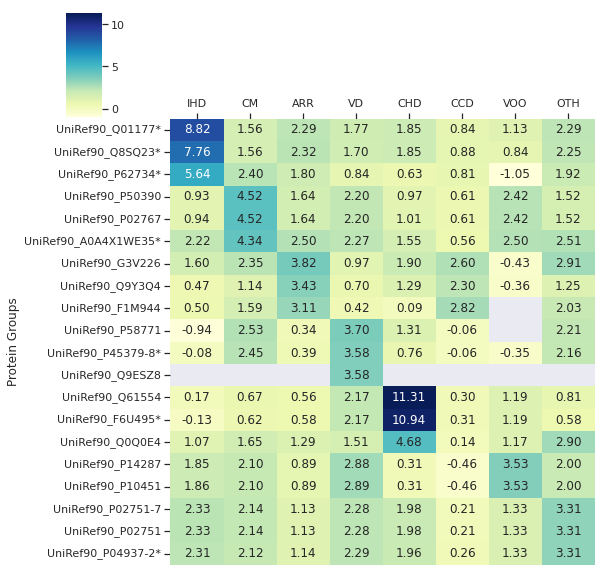

In [83]:
make_category_ii_heatmap(summary_table)

In [85]:
merged[merged.index.str.contains("UniRef90_Q01177")]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_Q01177; UniRef90_P06867; UniRef90_P20918; UniRef90_A6PVI2,Q01177; P06867; F1SB81; P20918; A6PVI2,"Plasminogen, plasminogen",0.163017,0.042481,0.052049,0.041846,0.042741,0.03464,0.033101,0.050448


In [86]:
merged[merged.index.str.contains("UniRef90_Q8SQ23")]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_Q8SQ23; UniRef90_P00750-3,F1SE20; B4DN26; E7ESF4,"Plasminogen activator, PLAT, plasminogen Activator, plasminogen activator, Plasminogen Activator",0.14585,0.042469,0.052536,0.041022,0.042691,0.035393,0.029675,0.049976


In [87]:
merged[merged.index.str.contains("UniRef90_P62734")]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P62734; UniRef90_P02144; UniRef90_P02156; UniRef90_P04247,B0QYF7; Q8WVH6; F2Z2F1; P02144; P02189; B0QYF8; F2Z337; Q9QZ76; P04247,"myoglobin, Myoglobin",0.111786,0.054325,0.045013,0.029834,0.02634,0.033972,0.007097,0.045617


In [34]:
merged[merged.index == "UniRef90_P02751-7"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P02751-7,H0Y4K8; F1SS24; H0Y7Z1,"Fibronectin, FN1, fibronectin",0.058347,0.050659,0.035483,0.048538,0.044552,0.023183,0.035426,0.063862


In [35]:
merged[merged.index == "UniRef90_P02751"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P02751,P02751,"Fibronectin, FN1, cold-insoluble globulin, fibronectin",0.058345,0.050696,0.035483,0.048537,0.044551,0.023183,0.035425,0.063861


In [36]:
merged[merged.index == "UniRef90_P04937-2; UniRef90_P04937; UniRef90_P11276"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P04937-2; UniRef90_P04937; UniRef90_P11276,F1LST1; P04937; A0A096P6L8; P11276,"Fibronectin, Fn1, fibronectin",0.058086,0.050383,0.035511,0.048575,0.044253,0.024172,0.035453,0.063786


TODO:
* For the ones that look the same values, what are the differences? in terms of synonyms. -> explain why they're scored differently -DONE
* Fix the y-axis labels (right now not displayed). truncate? or just put UniRef90_ABCDEF* *multiple protein groups represented

CM:

UniRef90_P50390 has the protein groups A0A5S6GPG9; P50390 and the synonyms Transthyretin, prealbumin, TTHY, Prealbumin, transthyretin. 

UniRef90_P02767 has the protein groups P07309; P02767 and the synonyms TBPA, Transthyretin, prealbumin, TTHY, Prealbumin, transthyretin. 

TBPA is a synonym for UniRef90_P02767 but not for UniRef90_P50390.




VOO:

UniRef90_P14287 has the protein group P14287 and the synonyms SPP1, Osteopontin, secreted phosphoprotein 1, Secreted phosphoprotein 1, osteopontin. 

UniRef90_P10451 has the protein group P10451 and the protein groups uropontin, SPP1, Osteopontin, secreted phosphoprotein 1, Secreted phosphoprotein 1, osteopontin. 

Uropontin is a synonym for UniRef90_P10451 but not for UniRef90_P14287.



OTH: 

UniRef90_P02751-7 has the proteins H0Y4K8; F1SS24; H0Y7Z1 and the synonyms fibronectin, Fibronectin, FN1.

UniRef90_P02751 has the protein P02751 and the synonyms fibronectin, Fibronectin, FN1, cold-insoluble globulin. This entry is different from the other two because it includes cold-insoluble globin as a synonym. 

UniRef90_P04937-2; UniRef90_P04937; UniRef90_P11276	has the proteins F1LST1; P04937; A0A096P6L8; P11276 and the synonyms fibronectin, Fibronectin, Fn1. This entry is unique from the other two because Fn1 is a synonym in this entry but the other two have it as FN1. It a difference in cases.   



## 3.4 Category III Protein Groups

In [37]:
combs = get_combinations(CVDs)

In [38]:
# calculate new category III columns
category_iii_headers=[]
for combination in combs:

    #gets the cvds that are not the ones of current interest 
    cvd_other = [other for other in CVDs if (other not in list(combination))] 
    # print(combination, cvd_other)

    #accesses the sub-proteome columns of the "other" cvds
    cvd_other = [x+" Sub-proteome" for x in cvd_other]

    #gets the cvds that are the ones of current interest 
    #cvd_interest = [interest for interest in CVDs if (interest == cvd)]

    #accesses the sub-proteome columns of the cvds of interest
    cvd_interest = [x+" Sub-proteome" for x in combination]

    #the new category column is if the sub-proteomes of interest are >= 3 and the other sub-proteomes are <= 3
    summary_table[combination] = ((summary_table[cvd_interest]).all(bool_only=True,axis='columns')) & ~((summary_table[cvd_other]).any(bool_only=True,axis='columns'))

    category_iii_headers += [combination]
    
summary_table[category_iii_headers].sort_values(category_iii_headers[0], ascending=False).head()


/home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,"(IHD, CM)","(IHD, ARR)","(IHD, VD)","(IHD, CHD)","(IHD, CCD)","(IHD, VOO)","(IHD, OTH)","(CM, ARR)","(CM, VD)","(CM, CHD)",...,"(ARR, VD, CHD, CCD, VOO, OTH)","(IHD, CM, ARR, VD, CHD, CCD, VOO)","(IHD, CM, ARR, VD, CHD, CCD, OTH)","(IHD, CM, ARR, VD, CHD, VOO, OTH)","(IHD, CM, ARR, VD, CCD, VOO, OTH)","(IHD, CM, ARR, CHD, CCD, VOO, OTH)","(IHD, CM, VD, CHD, CCD, VOO, OTH)","(IHD, ARR, VD, CHD, CCD, VOO, OTH)","(CM, ARR, VD, CHD, CCD, VOO, OTH)","(IHD, CM, ARR, VD, CHD, CCD, VOO, OTH)"
Protein Groups,,,,,,,,,,,,,,,,,,,,,
UniRef90_P04040; UniRef90_P04762,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
UniRef90_F7CJI9; UniRef90_A0A4X1T7M8,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
UniRef90_F5H4R2; UniRef90_P04179-2; UniRef90_F5GYZ5; UniRef90_Q8HXP7,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
UniRef90_A0A4X1SSR6,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
UniRef90_P70677; UniRef90_P55213,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
# print out summary statistics
counter = 0
upset_plot_dict = {}
for col_name in summary_table.columns[25:]:
    num_true = summary_table[col_name].sum()
    if num_true != 0:
        counter = counter +1
#         print("%s\t%d"%(col_name,num_true))
        upset_plot_dict[col_name] = num_true

# print(counter)
for l,c in upset_plot_dict.items():
    print(l,c)
print(len(upset_plot_dict))

('IHD', 'CM') 7
('IHD', 'ARR') 3
('IHD', 'CHD') 1
('CM', 'VD') 4
('CM', 'OTH') 11
('ARR', 'CCD') 5
('VD', 'CHD') 1
('IHD', 'CM', 'VD') 2
('IHD', 'CM', 'OTH') 17
('IHD', 'ARR', 'OTH') 1
('IHD', 'VD', 'VOO') 1
('ARR', 'CHD', 'CCD') 5
('VD', 'CHD', 'VOO') 2
('IHD', 'CM', 'VD', 'OTH') 1
('CM', 'ARR', 'CHD', 'CCD') 2
15


### Upset plot

In [40]:


multi_index_categories = get_bool_table(list(upset_plot_dict.keys()),ordering=CVDs)
# multi_index_categories
data_series = pd.Series(data=upset_plot_dict.values(),index=multi_index_categories)
data_series

IHD    CM     ARR    VD     CHD    CCD    VOO    OTH  
True   True   False  False  False  False  False  False     7
       False  True   False  False  False  False  False     3
              False  False  True   False  False  False     1
False  True   False  True   False  False  False  False     4
                     False  False  False  False  True     11
       False  True   False  False  True   False  False     5
              False  True   True   False  False  False     1
True   True   False  True   False  False  False  False     2
                     False  False  False  False  True     17
       False  True   False  False  False  False  True      1
              False  True   False  False  True   False     1
False  False  True   False  True   True   False  False     5
              False  True   True   False  True   False     2
True   True   False  True   False  False  False  True      1
False  True   True   False  True   True   False  False     2
dtype: int64

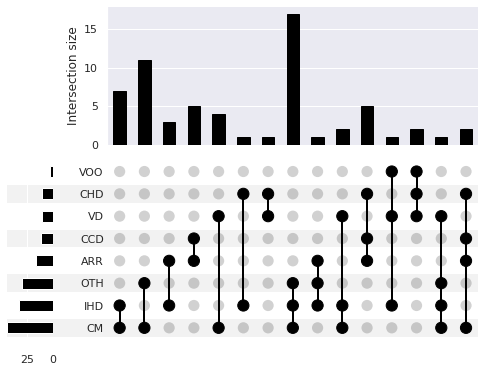

In [41]:
upplot(data_series)
plt.show()

## 3.5 Save output results

In [42]:
summary_table['Mapped Proteins'] = merged['Mapped Proteins']
summary_table['Synonyms'] = merged['Synonyms']
new_order = ['Mapped Proteins', 'Synonyms'] + list(summary_table.columns[:-2])
summary_table = summary_table[new_order]
summary_table.head()

/home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH,...,"(ARR, VD, CHD, CCD, VOO, OTH)","(IHD, CM, ARR, VD, CHD, CCD, VOO)","(IHD, CM, ARR, VD, CHD, CCD, OTH)","(IHD, CM, ARR, VD, CHD, VOO, OTH)","(IHD, CM, ARR, VD, CCD, VOO, OTH)","(IHD, CM, ARR, CHD, CCD, VOO, OTH)","(IHD, CM, VD, CHD, CCD, VOO, OTH)","(IHD, ARR, VD, CHD, CCD, VOO, OTH)","(CM, ARR, VD, CHD, CCD, VOO, OTH)","(IHD, CM, ARR, VD, CHD, CCD, VOO, OTH)"
Protein Groups,,,,,,,,,,,,,,,,,,,,,
UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,F8W930; Q9Y6M1; F1SFK0,IGF2BP2,NaN,-0.452850,NaN,-0.214451,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,B1AUU8; P42566; S4R3U1,epidermal growth factor receptor substrate 15,-0.716108,-0.766405,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
UniRef90_F1SID7,F1SID7,"Myosin Binding Protein C3, myosin binding protein C3, MYBPC3, Myosin binding protein C3",0.109163,3.511620,0.923204,7.245177,1.098864,0.492113,-0.708644,2.179917,...,False,False,False,False,False,False,False,False,False,False
UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,A0A0A0MSR2; E7EV99; D6RJE2; H0YG19; P35611; E7ENY0; H0Y9H2; D6RAH3; D6RF25,"ADD1, alpha-Adducin, Alpha-adducin, alpha-adducin",0.745009,-1.015601,NaN,NaN,-0.827650,NaN,NaN,-0.318482,...,False,False,False,False,False,False,False,False,False,False
UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,E9PKI8; E9PM01; F2Z393,"transaldolase, TALDO1",NaN,-0.091847,NaN,NaN,NaN,NaN,NaN,-1.084649,...,False,False,False,False,False,False,False,False,False,False


In [43]:
# write table
summary_table.to_csv('./results/SupplementaryData2_Summary_Table.csv')

# 4. Pathway Analysis

In [44]:
### cvd subproteome protein lists ###
print("### CVD Sub-proteomes ###")
cvd_subproteome_unirefs = {}
cvd_subproteome_proteins = {}
for cvd in cvds:
    tag = "%s Sub-proteome"%(cvd)
    unirefs = list(summary_table[summary_table[tag]].index)
    proteins = convert_uniref_ids_to_proteins(unirefs,uniref_to_uniprot_list)
    print("%s: %d unirefs %d proteins"%(tag, len(unirefs),len(proteins)))

    cvd_subproteome_unirefs[cvd] = unirefs
    cvd_subproteome_proteins[cvd] = proteins
    
### category i protein lists ###
print("### Category I ###")
category_i_unirefs = list(summary_table[summary_table['Category I']].index)
category_i_proteins = convert_uniref_ids_to_proteins(category_i_unirefs,uniref_to_uniprot_list)
print("%d uniref ids and %d uniref proteins in Category I"%(len(category_i_unirefs),len(category_i_proteins)))

### category ii protein lists ###
print("### Category II ###")
category_ii_unirefs = {}
category_ii_proteins = {}
for cvd in cvds:
    tag = "%s Category II"%(cvd)
    unirefs = list(summary_table[summary_table[tag]].index)
    proteins = convert_uniref_ids_to_proteins(unirefs,uniref_to_uniprot_list)
    print("%s: %d unirefs %d proteins"%(tag, len(unirefs),len(proteins)))

    category_ii_unirefs[cvd] = unirefs
    category_ii_proteins[cvd] = proteins

### CVD Sub-proteomes ###
IHD Sub-proteome: 55 unirefs 132 proteins
CM Sub-proteome: 65 unirefs 159 proteins
ARR Sub-proteome: 19 unirefs 37 proteins
VD Sub-proteome: 17 unirefs 49 proteins
CHD Sub-proteome: 35 unirefs 69 proteins
CCD Sub-proteome: 12 unirefs 22 proteins
VOO Sub-proteome: 5 unirefs 16 proteins
OTH Sub-proteome: 34 unirefs 95 proteins
### Category I ###
335 uniref ids and 827 uniref proteins in Category I
### Category II ###
IHD Category II: 22 unirefs 56 proteins
CM Category II: 21 unirefs 47 proteins
ARR Category II: 3 unirefs 3 proteins
VD Category II: 6 unirefs 19 proteins
CHD Category II: 24 unirefs 44 proteins
CCD Category II: 0 unirefs 0 proteins
VOO Category II: 2 unirefs 2 proteins
OTH Category II: 4 unirefs 10 proteins


In [48]:
for cvd in cvds:
    proteins = cvd_subproteome_proteins[cvd]
    
    if len(proteins) > 0:
        out_name = "./reactome_results/%s_subproteome_pathway_analysis_result.csv"%cvd
        pwa_df = submit_reactome_pathway_analysis(proteins, out_file = out_name)
        num_pathways = pwa_df.shape[0]
        print("%d pathways identified. Saved to %s"%(num_pathways,out_name))
    else:
        print("Insufficient number of proteins for %s"%cvd)

Saved to file ./reactome_results/IHD_subproteome_pathway_analysis_result.csv
309 pathways identified. Saved to ./reactome_results/IHD_subproteome_pathway_analysis_result.csv
Saved to file ./reactome_results/CM_subproteome_pathway_analysis_result.csv
388 pathways identified. Saved to ./reactome_results/CM_subproteome_pathway_analysis_result.csv
Saved to file ./reactome_results/ARR_subproteome_pathway_analysis_result.csv
54 pathways identified. Saved to ./reactome_results/ARR_subproteome_pathway_analysis_result.csv
Saved to file ./reactome_results/VD_subproteome_pathway_analysis_result.csv
147 pathways identified. Saved to ./reactome_results/VD_subproteome_pathway_analysis_result.csv
Saved to file ./reactome_results/CHD_subproteome_pathway_analysis_result.csv
289 pathways identified. Saved to ./reactome_results/CHD_subproteome_pathway_analysis_result.csv
Saved to file ./reactome_results/CCD_subproteome_pathway_analysis_result.csv
17 pathways identified. Saved to ./reactome_results/CCD_su

In [49]:
# run pathway analysis for category i proteins
cat_i_pa_result_df = submit_reactome_pathway_analysis(category_i_proteins, debug=True,
                            out_file = "./reactome_results/category_i_proteins_pathway_analysis_result.csv")
cat_i_pa_result_df.head()

Sucessfully posted pathway analysis with token MjAyMjA3MjAwNDU2NDBfMTcxNDM%3D
Saved to file ./reactome_results/category_i_proteins_pathway_analysis_result.csv


,Pathway identifier,Pathway name,#Entities found,#Entities total,Entities ratio,Entities pValue,Entities FDR,#Reactions found,#Reactions total,Reactions ratio,Species identifier,Species name,Submitted entities found,Mapped entities,Found reaction identifiers
1,R-HSA-76005,Response to elevated platelet cytosolic Ca2+,21,148,0.009774138158763703,2.1659192886991363E-6,0.002529793729200591,10,14,0.0010048808498420902,9606,Homo sapiens,P08758;F1SS24;F1RNJ0;Q64727;P48036;F2Z5C1;P20918;F1SL22;P04937;Q01177;P10111;Q01102;Q07969;P40241;P21926;P85972;Q08857;P02647;P05371;P01137;P09535;P08567;Q8WZ42;F1RV14;P01033;P04202;P26234;Q8CIZ8;P16109;P14668;P11276;Q9JHK5;Q06890;P17742;P18206;Q29549;P17246;P11021;P16671;P01009;P07200;P04275;P61812;Q4KM33;P01344;P02751;P10909,,R-HSA-482775;R-HSA-481044;R-HSA-482772;R-HSA-481010;R-HSA-482770;R-HSA-481007;R-HSA-114553;R-HSA-114683;R-HSA-114684;R-HSA-351323
2,R-HSA-114608,Platelet degranulation,19,141,0.0093118478404438,1.3252049189893533E-5,0.0077391967268978235,7,11,7.895492391616423E-4,9606,Homo sapiens,P08758;F1SS24;Q64727;P48036;F2Z5C1;P20918;F1SL22;P04937;Q01177;P10111;Q01102;Q07969;P40241;P21926;P85972;Q08857;P02647;P05371;P01137;P09535;P08567;Q8WZ42;P01033;P04202;P26234;Q8CIZ8;P16109;P14668;P11276;Q9JHK5;Q06890;P17742;P18206;Q29549;P17246;P11021;P16671;P01009;P07200;P04275;P61812;Q4KM33;P01344;P02751;P10909,,R-HSA-482775;R-HSA-481044;R-HSA-482772;R-HSA-481010;R-HSA-482770;R-HSA-481007;R-HSA-351323
3,R-HSA-76002,"Platelet activation, signaling and aggregation",28,293,0.019350151895390307,7.162383697068009E-5,0.027861672581594554,45,117,0.008397932816537468,9606,Homo sapiens,P08758;P02452;F1SS24;P28482;P20918;F2Z5C1;Q01177;P10111;P40241;P21926;P02647;P05371;P47713;P09535;P08567;P46108;P47712;P01033;P04202;P26234;P18292;P27361;P19221;P16109;Q06890;P18206;Q29549;P17246;P11021;P16671;P00734;P07200;P01344;P02751;F1RNJ0;Q64727;P48036;F1SL22;P04937;P21708;Q07969;Q01102;P85972;Q08857;P01137;Q8WZ42;F1RV14;Q63768;Q63844;Q8CIZ8;P31749;Q64010;P14668;P11276;Q9JHK5;P17742;P01009;P04275;Q4KM33;P61812;P10909,,R-HSA-139842;R-HSA-418176;R-HSA-429441;R-HSA-114697;R-HSA-354124;R-HSA-443402;R-HSA-372693;R-HSA-482775;R-HSA-481044;R-HSA-482772;R-HSA-482770;R-HSA-430096;R-HSA-453200;R-HSA-354066;R-HSA-372697;R-HSA-443418;R-HSA-354073;R-HSA-351323;R-HSA-418200;R-HSA-429529;R-HSA-354149;R-HSA-429415;R-HSA-354087;R-HSA-372705;R-HSA-428961;R-HSA-481007;R-HSA-418158;R-HSA-432110;R-HSA-377644;R-HSA-114600;R-HSA-377641;R-HSA-377640;R-HSA-377643;R-HSA-9708859;R-HSA-354165;R-HSA-481010;R-HSA-418163;R-HSA-114553;R-HSA-437118;R-HSA-453183;R-HSA-430076;R-HSA-114683;R-HSA-418170;R-HSA-114684;R-HSA-430073
4,R-HSA-6802948,Signaling by high-kinase activity BRAF mutants,9,44,0.0029058248580108308,1.301698098850057E-4,0.038009584486421666,6,6,4.306632213608958E-4,9606,Homo sapiens,F1SS24;P26234;Q6QAQ1;Q63844;Q64727;P60709;Q8CIZ8;P28482;P27361;F1SL22;P04937;Q02750;P21708;P11276;P18206;P15056;P85972;P04275;P02751;P60711;P60710,,R-HSA-6802930;R-HSA-6802912;R-HSA-6802911;R-HSA-6802910;R-HSA-6803227;R-HSA-6802938
5,R-HSA-397014,Muscle contraction,23,232,0.015321621978602562,1.8468552109296432E-4,0.04167825554518578,23,53,0.003804191788687913,9606,Homo sapiens,Q14524;P23693;Q8CG03;Q64727;Q99593;Q13936;P52952;P70326;P63267;P19429;P63268;I3LS66;P85972;P48787;P20595;P20152;P43694;P63269;P45379;P07355;P02543;Q8WZ42;F1RKD2;E9Q401;P02540;Q14896;P26234;Q15746;Q02153;Q4ZHR8;P11532;P31001;P31000;P17661;P33402;P11531;P11530;O76074;B0LPN4;P18206;Q02108;P08670;I3LUZ9;Q61391;P08473;P48675;P08133,,R-HSA-390597;R-HSA-445700;R-HSA-390598;R-HSA-9727607;R-HSA-445797;R-HSA-390593;R-HSA-445699;R-HSA-390595;R-HSA-2855020;R-HSA-5577213;R-HSA-9621179;R-HSA-392143;R-HSA-5576895;R-HSA-445704;R-HSA-5617179;R-HSA-445705;R-HSA-445813;R-HSA-9620456;R-HSA-5263628;R-HSA-9708104;R-HSA-392152;R-HSA-9614031;R-HSA-2032800


In [50]:
category_ii_pa_df = {}
for cvd in cvds:
    proteins = category_ii_proteins[cvd]
    
    if len(proteins) > 0:
        out_name = "./reactome_results/%s_category_ii_pathway_analysis_result.csv"%cvd
        pwa_df = submit_reactome_pathway_analysis(proteins, out_file = out_name)
        num_pathways = pwa_df.shape[0]
        print("%d pathways identified. Saved to %s"%(num_pathways,out_name))
    else:
        print("Insufficient number of proteins for %s"%cvd)

Saved to file ./reactome_results/IHD_category_ii_pathway_analysis_result.csv
87 pathways identified. Saved to ./reactome_results/IHD_category_ii_pathway_analysis_result.csv
Saved to file ./reactome_results/CM_category_ii_pathway_analysis_result.csv
118 pathways identified. Saved to ./reactome_results/CM_category_ii_pathway_analysis_result.csv
Saved to file ./reactome_results/ARR_category_ii_pathway_analysis_result.csv
3 pathways identified. Saved to ./reactome_results/ARR_category_ii_pathway_analysis_result.csv
Saved to file ./reactome_results/VD_category_ii_pathway_analysis_result.csv
3 pathways identified. Saved to ./reactome_results/VD_category_ii_pathway_analysis_result.csv
Saved to file ./reactome_results/CHD_category_ii_pathway_analysis_result.csv
227 pathways identified. Saved to ./reactome_results/CHD_category_ii_pathway_analysis_result.csv
Insufficient number of proteins for CCD
Saved to file ./reactome_results/VOO_category_ii_pathway_analysis_result.csv
15 pathways identified

In [51]:
# all proteins?
all_unirefs = list(uniref_to_uniprot_list.keys())
all_proteins = set()
for proteins in uniref_to_uniprot_list.values():
    all_proteins = all_proteins.union(set(proteins))
print("%d unirefs and %d proteins"%(len(all_unirefs),len(all_proteins)))

out_name = "./reactome_results/all_proteins_pathway_analysis_result.csv"
pwa_df = submit_reactome_pathway_analysis(all_proteins, out_file = out_name)
num_pathways = pwa_df.shape[0]
print("%d pathways identified. Saved to %s"%(num_pathways,out_name))

21732 unirefs and 30571 proteins
Saved to file ./reactome_results/all_proteins_pathway_analysis_result.csv
2213 pathways identified. Saved to ./reactome_results/all_proteins_pathway_analysis_result.csv


In [52]:
# proteins that had a score in each CVD at ALL
nonzero_cvd_uniref = {}
nonzero_cvd_proteins = {}
for cvd in cvds:
    
    # extract proteins
    unirefs = list(summary_table[summary_table[cvd] > 0].index)
    proteins = convert_uniref_ids_to_proteins(unirefs,uniref_to_uniprot_list)
    nonzero_cvd_uniref[cvd] = unirefs
    nonzero_cvd_proteins[cvd] = proteins
    print("%s: %d unirefs %d proteins"%(cvd, len(unirefs),len(proteins)))
    
    # pathway analysis
    if len(proteins) > 0:
        out_name = "./reactome_results/%s_nonzero_proteins_pathway_analysis_result.csv"%cvd
        pwa_df = submit_reactome_pathway_analysis(proteins, out_file = out_name)
        num_pathways = pwa_df.shape[0]
        print("%d pathways identified. Saved to %s"%(num_pathways,out_name))
    else:
        print("Insufficient number of proteins for %s"%cvd)

IHD: 1415 unirefs 3308 proteins
Saved to file ./reactome_results/IHD_nonzero_proteins_pathway_analysis_result.csv
1719 pathways identified. Saved to ./reactome_results/IHD_nonzero_proteins_pathway_analysis_result.csv
CM: 1541 unirefs 3678 proteins
Saved to file ./reactome_results/CM_nonzero_proteins_pathway_analysis_result.csv
1728 pathways identified. Saved to ./reactome_results/CM_nonzero_proteins_pathway_analysis_result.csv
ARR: 688 unirefs 1646 proteins
Saved to file ./reactome_results/ARR_nonzero_proteins_pathway_analysis_result.csv
1412 pathways identified. Saved to ./reactome_results/ARR_nonzero_proteins_pathway_analysis_result.csv
VD: 716 unirefs 1697 proteins
Saved to file ./reactome_results/VD_nonzero_proteins_pathway_analysis_result.csv
1335 pathways identified. Saved to ./reactome_results/VD_nonzero_proteins_pathway_analysis_result.csv
CHD: 917 unirefs 2144 proteins
Saved to file ./reactome_results/CHD_nonzero_proteins_pathway_analysis_result.csv
1538 pathways identified. S

# Load Reactome Data

In [53]:
# Load in the reactome hierarchial information for human. See function definition in first cell.
hierarchical_relationships, unique_reactome_ids = \
    extract_human_hierarchical_information(reactome_hierarchy_to_pathway)

# Load in pathway id to proteins relationships. See function definition in first cell.
reactome_pathway_to_unique_proteins = extract_pathway_to_proteins(reactome_uniprot_to_pathway,
                                            exclude_isoforms = False)

# Load in mapping of reactome pathway id to pathway name
pathway_id_to_pathway_name = extract_pathway_id_to_pathway_name(reactome_id_to_pathway_name)

Number of edges: 2603
Number of nodes: 2585
Number of pathways extracted: 21906
Number of pathways extracted with > 0 proteins: 21906
Mean pathway size: 40.85634072856752
Median pathway size: 13.0
Standard deviation pathway size: 109.56465750593985


In [54]:
# Create the graph
G = nx.DiGraph()
G.name = 'Reactome hierarchical tree'
G.add_edges_from(hierarchical_relationships)
print(nx.info(G))

DiGraph named 'Reactome hierarchical tree' with 2585 nodes and 2603 edges


In [55]:
# Calculate the familiar relations of each node
# That is, label a node based on its membership as a descendent of a specific set of pathways (root and parent pathways)

root_nodes = [x for x in G.nodes() if G.out_degree(x)>0 and G.in_degree(x)==0]
print("Number of root nodes: "+str(len(root_nodes)))

print("### Root Pathway Descendants ###")
descendants = get_descendant_pathways(root_nodes, G)
root_pathway_familiar_relations = get_familiar_relations(descendants)

Number of root nodes: 29
### Root Pathway Descendants ###


In [56]:
# Prune graph based on membership to root pathway
pruned_G_root_pathways = prune_extra_edges(G, 
                            labeling_function = root_pathway_familiar_relations, 
                            debug=False)
pruned_G_root_pathways.name = 'Reactome hierarchical tree pruned with root pathway membership'
print(nx.info(pruned_G_root_pathways))

Pruned 47 edges.
DiGraph named 'Reactome hierarchical tree pruned with root pathway membership' with 2586 nodes and 2585 edges


# Gather data for Pathway Analysis Heatmap in common between CVDs

In [57]:
# read all pathway analysis results into dataframes

pathway_analysis_directory = './reactome_results'
title_to_df = {}
for filename in os.listdir(pathway_analysis_directory):
    if filename.endswith(".csv"):
        pwa_file = os.path.join(pathway_analysis_directory, filename)
        
        # rename some keys for formatting
        tag = filename.split("_")[0] # cvd abbreviation
        if "category_ii" in filename:
            tag += "_unique"
        elif "subproteome" in filename:
            tag += '_subproteome'
        elif "nonzero" in filename:
            tag += "_nonzero"
        elif "category_i" in filename:
            tag = "category_i"
        elif "all" in filename:
            tag = "all_proteins"
        
        title_to_df[tag] = pd.read_csv(pwa_file)
        
    else:
        continue
reactome_results = title_to_df['category_i']
print(title_to_df.keys())

dict_keys(['CHD_nonzero', 'VD_subproteome', 'ARR_unique', 'VD_nonzero', 'IHD_unique', 'category_i', 'ARR_nonzero', 'OTH_nonzero', 'OTH_subproteome', 'CCD_nonzero', 'CM_subproteome', 'all_proteins', 'IHD_subproteome', 'VD_unique', 'CHD_unique', 'OTH_unique', 'CCD_subproteome', 'CM_unique', 'ARR_subproteome', 'CM_nonzero', 'VOO_unique', 'VOO_nonzero', 'IHD_nonzero', 'VOO_subproteome', 'CHD_subproteome'])


In [58]:
# make heatmap using these values
heatmap_data, pathways_in_heatmap = extract_heatmap_data(title_to_df)
heatmap_data = heatmap_data[cvds]
heatmap_data

15


,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Response to elevated platelet cytosolic Ca2+,0.378378,0.297297,0.175676,0.189189,0.195946,0.074324,0.121622,0.243243
Platelet degranulation,0.382979,0.297872,0.170213,0.184397,0.191489,0.063830,0.113475,0.241135
"Platelet activation, signaling and aggregation",0.235495,0.204778,0.129693,0.133106,0.156997,0.058020,0.092150,0.180887
Signaling by high-kinase activity BRAF mutants,0.318182,0.295455,0.204545,0.295455,0.363636,0.113636,0.159091,0.295455
Muscle contraction,0.185345,0.250000,0.211207,0.172414,0.189655,0.163793,0.056034,0.245690
Syndecan interactions,0.413793,0.344828,0.275862,0.344828,0.310345,0.103448,0.206897,0.310345
MAP2K and MAPK activation,0.285714,0.265306,0.183673,0.265306,0.326531,0.102041,0.142857,0.265306
Signaling by RAF1 mutants,0.326531,0.326531,0.224490,0.285714,0.326531,0.122449,0.142857,0.306122
Negative feedback regulation of MAPK pathway,0.500000,0.625000,0.375000,0.625000,0.750000,0.125000,0.375000,0.625000
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),0.299213,0.244094,0.157480,0.157480,0.236220,0.062992,0.125984,0.196850


In [59]:
# remove these pathways from the heatmap
pathway_names_to_drop = ['Signaling downstream of RAS mutants',
                                                 'Paradoxical activation of RAF signaling by kinase inactive BRAF']
heatmap_data = heatmap_data.drop(labels=pathway_names_to_drop,axis=0)

# also need to drop them from the pathways_in_heatmap pathway id list
pids_to_remove = []
for pid in pathways_in_heatmap:
    pname = pathway_id_to_pathway_name[pid]

    if pname in pathway_names_to_drop:
        pids_to_remove += [pid]
for pid in pids_to_remove:
    pathways_in_heatmap.remove(pid)
    pname = pathway_id_to_pathway_name[pid]
    print("dropped %s, %s"%(pid,pname))
print(pathways_in_heatmap)
heatmap_data

dropped R-HSA-9649948, Signaling downstream of RAS mutants
dropped R-HSA-6802955, Paradoxical activation of RAF signaling by kinase inactive BRAF
['R-HSA-76005', 'R-HSA-114608', 'R-HSA-76002', 'R-HSA-6802948', 'R-HSA-397014', 'R-HSA-3000170', 'R-HSA-5674135', 'R-HSA-9656223', 'R-HSA-5674499', 'R-HSA-381426', 'R-HSA-6802946', 'R-HSA-6802949', 'R-HSA-879415']


,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Response to elevated platelet cytosolic Ca2+,0.378378,0.297297,0.175676,0.189189,0.195946,0.074324,0.121622,0.243243
Platelet degranulation,0.382979,0.297872,0.170213,0.184397,0.191489,0.063830,0.113475,0.241135
"Platelet activation, signaling and aggregation",0.235495,0.204778,0.129693,0.133106,0.156997,0.058020,0.092150,0.180887
Signaling by high-kinase activity BRAF mutants,0.318182,0.295455,0.204545,0.295455,0.363636,0.113636,0.159091,0.295455
Muscle contraction,0.185345,0.250000,0.211207,0.172414,0.189655,0.163793,0.056034,0.245690
Syndecan interactions,0.413793,0.344828,0.275862,0.344828,0.310345,0.103448,0.206897,0.310345
MAP2K and MAPK activation,0.285714,0.265306,0.183673,0.265306,0.326531,0.102041,0.142857,0.265306
Signaling by RAF1 mutants,0.326531,0.326531,0.224490,0.285714,0.326531,0.122449,0.142857,0.306122
Negative feedback regulation of MAPK pathway,0.500000,0.625000,0.375000,0.625000,0.750000,0.125000,0.375000,0.625000
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),0.299213,0.244094,0.157480,0.157480,0.236220,0.062992,0.125984,0.196850


In [60]:
print(pathways_in_heatmap)
print([pathway_id_to_pathway_name[p] for p in pathways_in_heatmap])

['R-HSA-76005', 'R-HSA-114608', 'R-HSA-76002', 'R-HSA-6802948', 'R-HSA-397014', 'R-HSA-3000170', 'R-HSA-5674135', 'R-HSA-9656223', 'R-HSA-5674499', 'R-HSA-381426', 'R-HSA-6802946', 'R-HSA-6802949', 'R-HSA-879415']
['Response to elevated platelet cytosolic Ca2+', 'Platelet degranulation ', 'Platelet activation, signaling and aggregation', 'Signaling by high-kinase activity BRAF mutants', 'Muscle contraction', 'Syndecan interactions', 'MAP2K and MAPK activation', 'Signaling by RAF1 mutants', 'Negative feedback regulation of MAPK pathway', 'Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)', 'Signaling by moderate kinase activity BRAF mutants', 'Signaling by RAS mutants', 'Advanced glycosylation endproduct receptor signaling']


In [61]:



# the results of putting all the proteins into reactome pathway analysis
all_union_pa_df = title_to_df['all_proteins']

# get reverse and forward mapping of uniprot proteins to uniref90 groups
uniref_to_uniprot_list = get_uniref_to_uniprot_list(prot_to_uniref_file)
uniprot_to_uniref = get_uniref_to_uniprot_list(prot_to_uniref_file, reverse_mapping=True)

# extract pathway to its set of corresponding CaseOLAP scores for each protein in that pathway
pathway_to_uniref_scores = extract_pathway_to_scores(pathways_in_heatmap, zscores_df, 
                                                    all_union_pa_df, uniprot_to_uniref, debug=True)

c_data = heatmap_data[cvds]
z_data = extract_pathway_avg_zscore_matrix(pathway_to_uniref_scores)
# relabel rows and reorder columns
z_data.index = [pathway_id_to_pathway_name[p] for p in z_data.index]
z_data = z_data[cvds]
# dend_data = linkage_matrix

       Pathway ID  Pathway size IHD  CM ARR  VD CHD CCD VOO OTH
0     R-HSA-76005           148  60  54  37  36  42  22  22  51
1    R-HSA-114608           141  56  51  35  34  40  20  20  48
2     R-HSA-76002           293  89  81  57  50  59  30  32  77
3   R-HSA-6802948            44  22  17  12   9  13   8   8  21
4    R-HSA-397014           232  44  65  49  37  55  32  14  61
5   R-HSA-3000170            29  21  18  14  11  16   9   9  17
6   R-HSA-5674135            49  22  17  12   9  14   8   8  21
7   R-HSA-9656223            49  24  17  13  11  14   8   8  20
8   R-HSA-5674499             8   8   7   8   7   8   5   6   7
9    R-HSA-381426           127  40  39  32  25  37  18  18  36
10  R-HSA-6802946            54  27  20  14  11  16   8   8  24
11  R-HSA-6802949            54  27  20  14  11  16   8   8  24
12   R-HSA-879415            16   8   8   8   8   8   7   8   8


In [62]:
z_data

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Response to elevated platelet cytosolic Ca2+,0.497076,0.367192,0.045901,0.193924,0.253158,-0.321169,-0.190737,0.185279
Platelet degranulation,0.432758,0.271612,-0.063098,0.131086,0.214587,-0.421515,-0.240357,0.085461
"Platelet activation, signaling and aggregation",0.341215,0.336635,-0.006879,0.227120,0.382956,-0.291078,-0.047021,0.187758
Signaling by high-kinase activity BRAF mutants,0.314082,0.510507,0.012205,1.265195,1.144730,-0.310101,0.583621,0.381757
Muscle contraction,0.213126,0.428219,1.115735,0.864511,0.731715,1.552078,0.069292,0.496850
Syndecan interactions,0.590809,0.340759,0.218309,0.707694,0.210845,-0.202404,0.190339,0.303135
MAP2K and MAPK activation,0.314082,0.510507,0.012205,1.265195,1.003870,-0.310101,0.583621,0.381757
Signaling by RAF1 mutants,0.472526,0.838164,0.127273,1.017422,0.993476,-0.310101,0.583621,0.563622
Negative feedback regulation of MAPK pathway,0.406818,1.409998,0.031384,1.303774,2.061082,-0.237824,0.468406,1.553174
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),0.656084,0.455707,0.029853,0.642775,0.646813,-0.334929,0.724747,0.470945


## Heatmap 1

Pruned 47 edges.


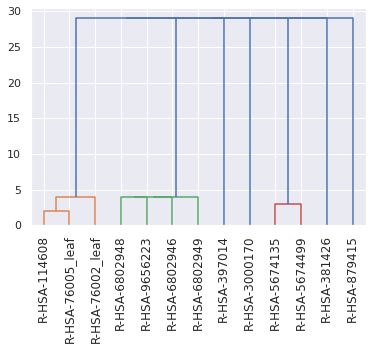

In [65]:
linkage_matrix, dendrogram_order = construct_dendrogram(G,pathways_in_heatmap,
                     labeling_function = root_pathway_familiar_relations,
                     debug=False)

In [66]:


reordered_c_data = reorder_heatmap(c_data, dendrogram_order, 
                            pathway_id_to_pathway_name, 
                            reactome_pathway_to_unique_proteins)

reordered_z_data = reorder_heatmap(z_data, dendrogram_order, 
                            pathway_id_to_pathway_name, 
                            reactome_pathway_to_unique_proteins)

In [67]:
c_data

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Response to elevated platelet cytosolic Ca2+,0.378378,0.297297,0.175676,0.189189,0.195946,0.074324,0.121622,0.243243
Platelet degranulation,0.382979,0.297872,0.170213,0.184397,0.191489,0.063830,0.113475,0.241135
"Platelet activation, signaling and aggregation",0.235495,0.204778,0.129693,0.133106,0.156997,0.058020,0.092150,0.180887
Signaling by high-kinase activity BRAF mutants,0.318182,0.295455,0.204545,0.295455,0.363636,0.113636,0.159091,0.295455
Muscle contraction,0.185345,0.250000,0.211207,0.172414,0.189655,0.163793,0.056034,0.245690
Syndecan interactions,0.413793,0.344828,0.275862,0.344828,0.310345,0.103448,0.206897,0.310345
MAP2K and MAPK activation,0.285714,0.265306,0.183673,0.265306,0.326531,0.102041,0.142857,0.265306
Signaling by RAF1 mutants,0.326531,0.326531,0.224490,0.285714,0.326531,0.122449,0.142857,0.306122
Negative feedback regulation of MAPK pathway,0.500000,0.625000,0.375000,0.625000,0.750000,0.125000,0.375000,0.625000
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),0.299213,0.244094,0.157480,0.157480,0.236220,0.062992,0.125984,0.196850


In [68]:
reordered_c_data

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Advanced glycosylation endproduct receptor signaling (13 proteins),0.375000,0.375000,0.375000,0.312500,0.375000,0.187500,0.250000,0.375000
Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs) (124 proteins),0.299213,0.244094,0.157480,0.157480,0.236220,0.062992,0.125984,0.196850
Negative feedback regulation of MAPK pathway (6 proteins),0.500000,0.625000,0.375000,0.625000,0.750000,0.125000,0.375000,0.625000
MAP2K and MAPK activation (41 proteins),0.285714,0.265306,0.183673,0.265306,0.326531,0.102041,0.142857,0.265306
Syndecan interactions (27 proteins),0.413793,0.344828,0.275862,0.344828,0.310345,0.103448,0.206897,0.310345
Muscle contraction (204 proteins),0.185345,0.250000,0.211207,0.172414,0.189655,0.163793,0.056034,0.245690
Signaling by RAS mutants (47 proteins),0.333333,0.333333,0.203704,0.277778,0.351852,0.111111,0.148148,0.314815
Signaling by moderate kinase activity BRAF mutants (47 proteins),0.333333,0.333333,0.203704,0.277778,0.351852,0.111111,0.148148,0.314815
Signaling by RAF1 mutants (42 proteins),0.326531,0.326531,0.224490,0.285714,0.326531,0.122449,0.142857,0.306122
Signaling by high-kinase activity BRAF mutants (37 proteins),0.318182,0.295455,0.204545,0.295455,0.363636,0.113636,0.159091,0.295455


/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)
/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:988: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


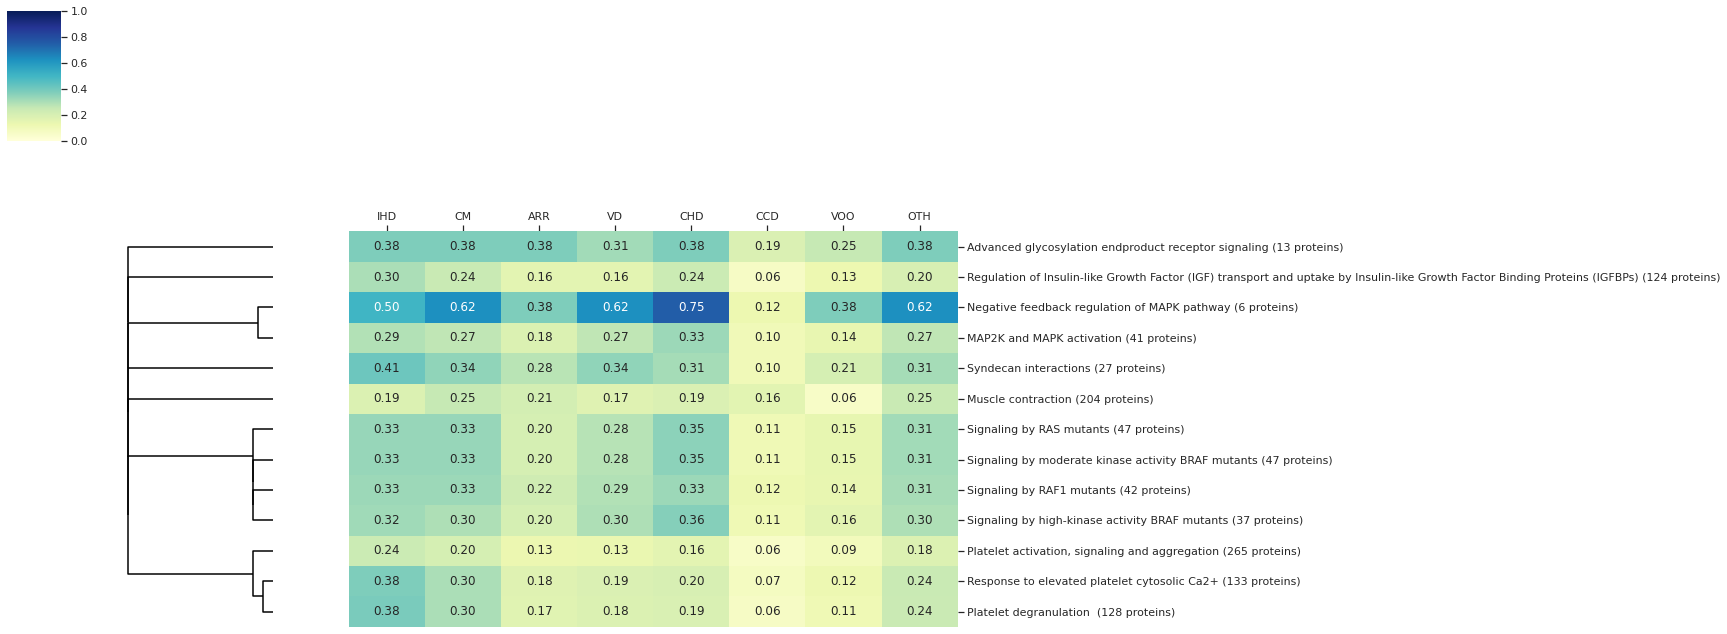

In [69]:

    
make_heatmap(reordered_c_data, linkage_matrix)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self._figure.tight_layout(**tight_params)
/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:988: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


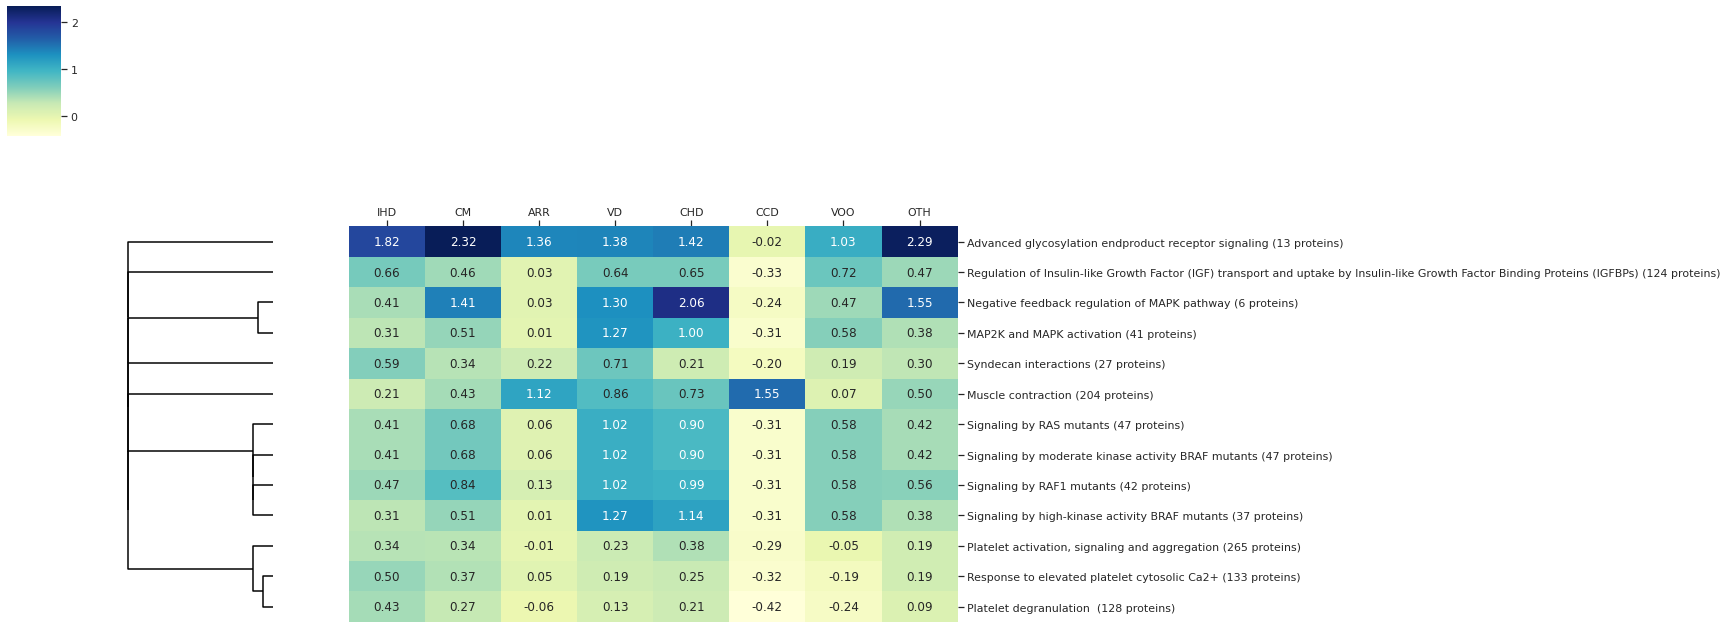

In [70]:
make_heatmap(reordered_z_data, linkage_matrix, v_lim=(None,None))

## Double heatmaps

/home/ubuntu/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/cardiac_proteome_caseolap/_03_text_mining_association_analysis.py:1138: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  f.savefig(out_file,box_inches = 'tight')


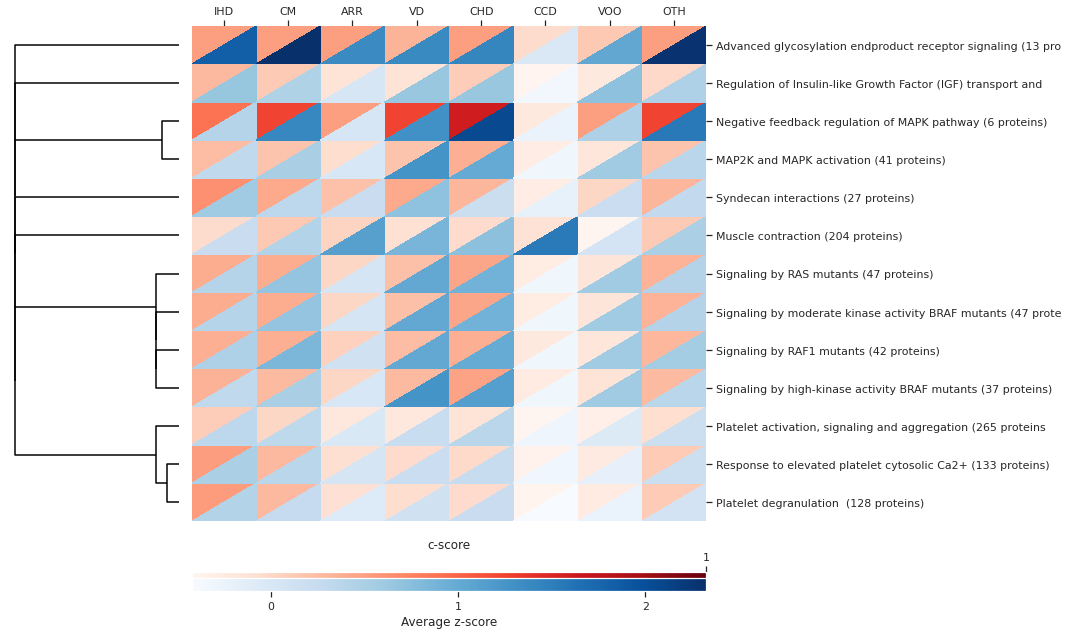

In [71]:
double_heatmap(reordered_c_data,reordered_z_data, linkage_matrix)

In [73]:
pathway_to_uniref_proteins_scores = add_proteins_to_uniref_scores(pathway_to_uniref_scores, 
                                                            reactome_results, uniref_to_uniprot_list,
                                                            pathway_id_to_pathway_name, 
                                                            reactome_pathway_to_unique_proteins)

KeyError: 0.865872787596687

In [74]:
save_pathway_to_proteins(dendrogram_order,pathway_id_to_pathway_name,reactome_pathway_to_unique_proteins)

FileNotFoundError: [Errno 2] No such file or directory: './output/heatmap_data/pathway_to_proteins.csv'

In [75]:
save_heatmap_data(reordered_c_data,reordered_z_data,
                  pathway_to_uniref_proteins_scores)  

NameError: name 'pathway_to_uniref_proteins_scores' is not defined

In [76]:
# extract scores for each CVD for each protein
# based on 2021-08-06 Pathway Analysis Post processing.ipynb for CVD Specific pathways

# extract pathway to mapped entities
all_df = title_to_df['all']
pathway_to_mapped_proteins = {}
for pathway,mapped_ent in zip(all_df['Pathway identifier'], all_df['Mapped entities']):
    pathway_to_mapped_proteins[pathway] = mapped_ent.split(";")
    #print("%s has %d mapped entities"%(pathway,len(pathway_to_mapped_proteins[pathway])))

# get uniref to zscore mapping
uniref_to_zscore = {}
for zscore_dict in zscores_df.to_dict('index').values():
    uniref = zscore_dict.pop('protein')
    uniref_to_zscore[uniref] = zscore_dict
    # print(uniref,str(uniref_to_zscore[uniref]))
print("%d UniRef ID's to zscore dicts"%(len(uniref_to_zscore)))

# map uniref IDs back to proteins
prot_to_uniref_file = "./all_intersect_proteins_to_uniref90.txt.tab"
map_df = pd.read_csv(prot_to_uniref_file, sep = "\t")
map_df.columns = ['UniProt list','UniRef90']
uniref_to_uniprot_list = {}
for upid_list, uniref_id in zip(map_df['UniProt list'], map_df['UniRef90']):
    if uniref_id not in uniref_to_uniprot_list:
        uniref_to_uniprot_list[uniref_id] = set()
    proteins = set(upid_list.split(","))
    uniref_to_uniprot_list[uniref_id] = uniref_to_uniprot_list[uniref_id].union(proteins)

# map these proteins to their corresponding zscore
protein_to_zscore_dict = {}
c = 0
num_uniref_without_zscore = 0
for uniref, uniprot_list in zip(uniref_to_uniprot_list.keys(),uniref_to_uniprot_list.values()):
    c+= 1
    if uniref in uniref_to_zscore:
        zscore_dict = uniref_to_zscore[uniref]
        for p in uniprot_list:
            protein_to_zscore_dict[p] = zscore_dict
    else:
        num_uniref_without_zscore += 1
print("%d proteins with a corresponding zscore dict"%(len(protein_to_zscore_dict)))
print("%d uniref IDs without a zscore dict"%num_uniref_without_zscore)
print(c)


KeyError: 'all'

In [77]:
# extract scores for each CVD for each protein
# based on 2021-08-06 Pathway Analysis Post processing.ipynb for CVD Specific pathways

# extract pathway to mapped entities
all_df = title_to_df['all']
pathway_to_mapped_proteins = {}
for pathway,mapped_ent in zip(all_df['Pathway identifier'], all_df['Mapped entities']):
    pathway_to_mapped_proteins[pathway] = mapped_ent.split(";")
    #print("%s has %d mapped entities"%(pathway,len(pathway_to_mapped_proteins[pathway])))

# map these proteins to their corresponding zscore
protein_to_zscore_dict = {}
c = 0
num_uniref_without_zscore = 0
for uniref, uniprot_list in zip(uniref_to_uniprot_list.keys(),uniref_to_uniprot_list.values()):
    c+= 1
    if uniref in uniref_to_zscore:
        zscore_dict = uniref_to_zscore[uniref]
        for p in uniprot_list:
            protein_to_zscore_dict[p] = zscore_dict
    else:
        num_uniref_without_zscore += 1
print("%d proteins with a corresponding zscore dict"%(len(protein_to_zscore_dict)))
print("%d uniref IDs without a zscore dict"%num_uniref_without_zscore)
print(c)

KeyError: 'all'

# Heatmap uniques to CVDs

In [78]:
unique_to_cvd_pathway_list = {}
for title, reactome_results_df in title_to_df.items():
    if "unique" in title:
        pathways = list(reactome_results_df['Pathway identifier'])
        temp_df = reactome_results_df.sort_values('Entities pValue',ascending=True) # make sure lowest pvalue is first
        cvd = title.split("_")[0]
        unique_to_cvd_pathway_list[cvd] = pathways[:3]
for cvd,p in unique_to_cvd_pathway_list.items():
    print("%s: %s"%(cvd,p))
    pathway_names = []
    for pp in p:
        pathway_names += [pathway_id_to_pathway_name[pp]]
    print(pathway_names)

ARR: ['R-HSA-1296061', 'R-HSA-1296071', 'R-HSA-112316']
['HCN channels', 'Potassium Channels', 'Neuronal System']
IHD: ['R-HSA-381426', 'R-HSA-75205', 'R-HSA-8963888']
['Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)', 'Dissolution of Fibrin Clot', 'Chylomicron assembly']
VD: ['R-HSA-390522', 'R-HSA-397014', 'R-HSA-445355']
['Striated Muscle Contraction', 'Muscle contraction', 'Smooth Muscle Contraction']
CHD: ['R-HSA-6802957', 'R-HSA-6802949', 'R-HSA-9649948']
['Oncogenic MAPK signaling', 'Signaling by RAS mutants', 'Signaling downstream of RAS mutants']
OTH: ['R-HSA-1566977', 'R-HSA-8951671', 'R-HSA-9700645']
['Fibronectin matrix formation', 'RUNX3 regulates YAP1-mediated transcription', 'ALK mutants bind TKIs']
CM: ['R-HSA-879415', 'R-HSA-418457', 'R-HSA-5620971']
['Advanced glycosylation endproduct receptor signaling', 'cGMP effects', 'Pyroptosis']
VOO: ['R-HSA-8949275', 'R-HSA-186797', 'R-HSA-216083']
['R

In [79]:
# we don't want pathways that are redundant to each other, so we'll re-run with an exclusion list.
pathways_to_ignore = ['R-HSA-749476', 'R-HSA-74158','R-HSA-9726840','R-HSA-9726842',
                                            'R-HSA-8964026','R-HSA-397014', 'R-HSA-9614085', 'R-HSA-8963888'
                                            'R-HSA-446193']

unique_to_cvd_pathway_list = {}
for title, reactome_results_df in title_to_df.items():
    if "unique" in title:
        pathways = list(reactome_results_df['Pathway identifier'])
        temp_df = reactome_results_df.sort_values('Entities pValue',ascending=True) # make sure lowest pvalue is first
        pathways_filtered = [p for p in pathways if p not in pathways_to_ignore] 
        cvd = title.split("_")[0]
        unique_to_cvd_pathway_list[cvd] = pathways_filtered[:3]
for cvd,p in unique_to_cvd_pathway_list.items():
    print("%s: %s"%(cvd,p))
    pathway_names = []
    for pp in p:
        pathway_names += [pathway_id_to_pathway_name[pp]]
    print(pathway_names)

ARR: ['R-HSA-1296061', 'R-HSA-1296071', 'R-HSA-112316']
['HCN channels', 'Potassium Channels', 'Neuronal System']
IHD: ['R-HSA-381426', 'R-HSA-75205', 'R-HSA-8963888']
['Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)', 'Dissolution of Fibrin Clot', 'Chylomicron assembly']
VD: ['R-HSA-390522', 'R-HSA-445355']
['Striated Muscle Contraction', 'Smooth Muscle Contraction']
CHD: ['R-HSA-6802957', 'R-HSA-6802949', 'R-HSA-9649948']
['Oncogenic MAPK signaling', 'Signaling by RAS mutants', 'Signaling downstream of RAS mutants']
OTH: ['R-HSA-1566977', 'R-HSA-8951671', 'R-HSA-9700645']
['Fibronectin matrix formation', 'RUNX3 regulates YAP1-mediated transcription', 'ALK mutants bind TKIs']
CM: ['R-HSA-879415', 'R-HSA-418457', 'R-HSA-5620971']
['Advanced glycosylation endproduct receptor signaling', 'cGMP effects', 'Pyroptosis']
VOO: ['R-HSA-8949275', 'R-HSA-186797', 'R-HSA-216083']
['RUNX3 Regulates Immune Response and Cel

In [80]:
for cvd in cvds:
    pathways = unique_to_cvd_pathway_list[cvd]
    print("%s: %s"%(cvd,pathways))

IHD: ['R-HSA-381426', 'R-HSA-75205', 'R-HSA-8963888']
CM: ['R-HSA-879415', 'R-HSA-418457', 'R-HSA-5620971']
ARR: ['R-HSA-1296061', 'R-HSA-1296071', 'R-HSA-112316']
VD: ['R-HSA-390522', 'R-HSA-445355']
CHD: ['R-HSA-6802957', 'R-HSA-6802949', 'R-HSA-9649948']


KeyError: 'CCD'

In [81]:


    
make_heatmap_unique_to_cvd(unique_to_cvd_pathway_list, zscores_df, 
                                                     all_union_pa_df, uniprot_to_uniref, cvds,
                                             pathway_id_to_pathway_name, reactome_pathway_to_unique_proteins)

KeyError: 'CCD'